In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats
import pywt
import os
import time
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec

from nilearn.connectome import ConnectivityMeasure
from sklearn.manifold import SpectralEmbedding
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances

from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.neighbors import NearestNeighbors
import networkx as nx


In [6]:
from fig_4_helper import catname
from fig_4_helper import NormalizeData, check_symmetric
from fig_4_helper import normalize_matrix, geodesic_distances

## Load data

In [7]:
figs_path = Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Figure_3\fig_3')

In [8]:
master_path = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data')

In [9]:
results_path = master_path / 'Embeddings' 

In [10]:
master_path = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data')
tensor =fl.load(master_path/ 'tensors' /'tensor_ipsi_contra_pos.h5')
features = pd.read_csv(master_path/ 'features_bouts_new.csv')

tail = tensor[:, 0]
fin_1 = tensor[:,1]
fin_2 = tensor[:,2]

fin_all = np.concatenate((fin_1 ,fin_2),axis=-1)

In [11]:
covariance_measure = ConnectivityMeasure(kind='covariance')
matrix_fins_cov = covariance_measure.fit_transform([fin_all.T])[0]

In [12]:
# fin space cov
matrix_fins_cov = np.cov(fin_all)
X = np.abs(matrix_fins_cov)
X[np.diag_indices_from(X)] = 0
embedding = SpectralEmbedding(n_components=15)
X_transformed = embedding.fit_transform(X)

### Run all the distances

In [13]:
print("Covariance distance ---- ")

distances = 1-X
distances[np.diag_indices_from(distances)] = 0

dist_ratio = np.zeros(11)
dist_in = np.zeros(11)
dist_out = np.zeros(11)

for i in range(11):
    selection = features.cluster.values == i
    ins = np.squeeze(np.argwhere(selection))
    not_ins = np.squeeze(np.argwhere(~selection))
    A_in = distances[ins,:].T[ins]
    A_out = distances[ins,:].T[not_ins]
    
    A_in[A_in == 0] = np.nan
    A_out[A_out == 0] = np.nan

    mean_in = np.nanmean(A_in)
    mean_out = np.nanmean(A_out)

    dist_in[i] = mean_in
    dist_out[i] = mean_out
    dist_ratio[i] = mean_in/mean_out

dist_ratio_cov_fin = dist_ratio
dist_ratio_cov_fin_mean_in = dist_in

Covariance distance ---- 


In [15]:
# Euclidean embedding k components
print("Euclidean embedding k components ---- ")
k = 3
distances = normalize_matrix(euclidean_distances(X_transformed[:,:k], X_transformed[:,:k]))

dist_ratio = np.zeros(11)
dist_in = np.zeros(11)
dist_out = np.zeros(11)

for i in range(11):
    selection = features.cluster.values == i
    ins = np.squeeze(np.argwhere(selection))
    not_ins = np.squeeze(np.argwhere(~selection))
    A_in = distances[ins,:].T[ins]
    A_out = distances[ins,:].T[not_ins]
    
    A_in[A_in == 0] = np.nan
    A_out[A_out == 0] = np.nan

    mean_in = np.nanmean(A_in)
    mean_out = np.nanmean(A_out)

    dist_in[i] = mean_in
    dist_out[i] = mean_out
    dist_ratio[i] = mean_in/mean_out

dist_ratio_emb_euc = dist_ratio
dist_ratio_emb_euc_mean_in = dist_in

Euclidean embedding k components ---- 


In [17]:
print("geodesic distance k components ---- ")

# geodesic distance k components
start_time = time.time()
distances =  normalize_matrix(geodesic_distances(X_transformed[:,:k],4,mymetric = 'euclidean'))
print("--- %s seconds ---" % (time.time() - start_time))
distances_geo =  distances

dist_ratio = np.zeros(11)
dist_in = np.zeros(11)
dist_out = np.zeros(11)

for i in range(11):
    selection = features.cluster.values == i
    ins = np.squeeze(np.argwhere(selection))
    not_ins = np.squeeze(np.argwhere(~selection))
    A_in = distances[ins,:].T[ins]
    A_out = distances[ins,:].T[not_ins]

    A_in[A_in == 0] = np.nan
    A_out[A_out == 0] = np.nan

    mean_in = np.nanmean(A_in)
    mean_out = np.nanmean(A_out)

    dist_in[i] = mean_in
    dist_out[i] = mean_out

    dist_ratio[i] = mean_in/mean_out

dist_ratio_emb_geo = dist_ratio

geodesic distance k components ---- 
--- 352.6542057991028 seconds ---


## Set parameters

In [20]:
cm = 1/2.54  # centimeters in inches
f_size = 6
size=2
lw=0.5
dpi = 600

### Panel B: Comparative Distance plot


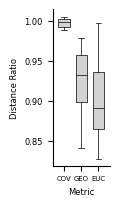

In [29]:
# Combine the data into a list
data = [dist_ratio_cov_fin, dist_ratio_emb_geo, dist_ratio_emb_euc]

# Create the boxplot
plt.figure(figsize=(3.3*cm, 5.5*cm))

# Plot the boxplot with specified positions and modify line widths
boxplot = plt.boxplot(data, patch_artist=True, widths=0.2, positions=[0.1, 0.4, 0.7],
                      medianprops={'color': 'black', 'linewidth': lw},
                      whiskerprops={'linewidth': lw},
                      capprops={'linewidth': lw},
                      boxprops={'linewidth': lw},
                      flierprops={'markerfacecolor': 'r', 'marker': 'o', 'markersize': 5, 'linestyle': 'none', 'linewidth': lw})

# Customize the boxplot appearance
colors = ['lightgray', 'lightgray', 'lightgray']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Axis labels and ticks
plt.xlabel('Metric', fontsize=f_size)
plt.ylabel('Distance Ratio', fontsize=f_size)
plt.yticks(fontsize=f_size)
plt.xticks([0.1, 0.4, 0.7], labels=['COV', 'GEO', 'EUC'], fontsize=f_size-1)
plt.xlim(-0.1, 0.9)

# Use seaborn to clean up the plot's axis lines
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()  # Adjust layout to make room for labels

plt.savefig(figs_path/'stereo_comp_dist.pdf'.format(figs_path),format="pdf",dpi=dpi,  bbox_inches="tight")
plt.savefig(figs_path/'stereo_comp_dist.png'.format(figs_path),format="png",dpi=dpi,  bbox_inches="tight")

## Panel C: Number of Components

In [23]:
# Euclidean coponents

components = np.arange(1,10,1)
dist_ratio_all = np.zeros((len(components),11))

for k in range(len(components)):
    distances = normalize_matrix(euclidean_distances(X_transformed[:,:components[k]], X_transformed[:,:components[k]]))
    dist_ratio = np.zeros(11)
    dist_in = np.zeros(11)
    dist_out = np.zeros(11)
    for i in range(11):
        selection = features.cluster.values == i
        ins = np.squeeze(np.argwhere(selection))
        not_ins = np.squeeze(np.argwhere(~selection))
        A_in = distances[ins,:].T[ins]
        A_out = distances

        A_in[A_in == 0] = np.nan
        A_out[A_out == 0] = np.nan

        mean_in = np.nanmean(A_in)
        mean_out = np.nanmean(A_out)
        dist_in[i] = mean_in
        dist_out[i] = mean_out
        dist_ratio[i] = mean_in/mean_out

    dist_ratio_all[k,:] = dist_ratio

0
1
2
3
4
5
6
7
8


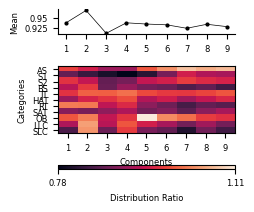

In [48]:
# Assuming dist_ratio_all, components, labels_cat, labels_cat_short, size, f_size, cm are previously defined
fig = plt.figure(figsize=(4.5*cm,4.5*cm))  # Removed *cm assuming it's a typo
gs = GridSpec(3, 1, height_ratios=[1.5, 4, 0.2]) 

ax1 = fig.add_subplot(gs[0])
ax1.plot(np.mean(dist_ratio_all, axis=1), 'ko-', markersize=size, lw=0.5)
ax1.set_xticks(range(len(components)))
ax1.set_xticklabels(components, fontsize=f_size)
ax1.set_ylabel('Mean', fontsize=f_size)
ax1.set_yticks([0.925, 0.950])
ax1.set_yticklabels([0.925, 0.950], fontsize=f_size)
sns.despine(top=True, right=True, left=False, bottom=False)

ax2 = fig.add_subplot(gs[1])
im = ax2.imshow(dist_ratio_all.T, interpolation='none', cmap='rocket', aspect='auto')
ax2.set_yticks(range(len(catname)))
ax2.set_yticklabels(catname, fontsize=f_size)
ax2.set_xticks(range(len(components)))
ax2.set_xticklabels(components, fontsize=f_size)
ax2.set_xlabel('Components', fontsize=f_size)
ax2.set_ylabel('Categories', fontsize=f_size)

cbar_ax = fig.add_subplot(gs[2])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')  # Pad set to 0.1
cbar.ax.tick_params(labelsize=f_size)
cbar.set_ticks([np.min(dist_ratio_all),np.max(dist_ratio_all)])
cbar.set_ticklabels([np.round(np.min(dist_ratio_all),2),np.round(np.max(dist_ratio_all),2)], fontsize=f_size)

cbar.set_label('Distribution Ratio', fontsize=f_size)
plt.subplots_adjust(hspace=0.01)  # Adjust space between subplots
plt.subplots_adjust(left=0, right=1, top=1, bottom=0.1, wspace=0.1, hspace=1)

fig.savefig('{}/stereo_comp_dist_cluster_{}.pdf'.format(figs_path, len(components)),format="pdf",dpi=dpi,  bbox_inches="tight")
fig.savefig('{}/stereo_comp_dist_cluster_{}.png'.format(figs_path, len(components)),format="png",dpi=dpi,  bbox_inches="tight")


## Panel E: Stereotypy Bout Categories

In [ ]:
ordered_indices = np.argsort(dist_ratio_emb_euc)

# Example array
array = dist_ratio_emb_euc[ordered_indices]
# Calculate the quantiles
q1 = np.percentile(array, 33)
q2 = np.percentile(array, 66)

# Split the array into three quantiles
first_quantile = array[array <= q1]
second_quantile = array[(array > q1) & (array <= q2)]
third_quantile = array[array > q2]

print("First quantile (0-33.33%):", first_quantile)
print("Second quantile (33.33-66.67%):", second_quantile)
print("Third quantile (66.67-100%):", third_quantile)
qs = [q1, q2]
print (qs)


First quantile (0-33.33%): [0.82828014 0.83939697 0.84557217 0.88551466]
Second quantile (33.33-66.67%): [0.8876444  0.89080112 0.89361094]
Third quantile (66.67-100%): [0.91447344 0.95810737 0.9939387  0.99680734]
[0.886153581724433, 0.906128436281326]


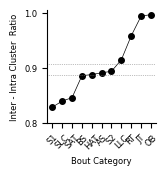

In [57]:
fig, axes = plt.subplots(figsize=(4.5*cm,4.7*cm))  # Removed *cm assuming it's a typo

axes.plot(dist_ratio_emb_euc[ordered_indices],'ko-', label = 'embedding space / euclidean', markersize=size*2, lw= lw)
plt.xticks(np.arange(0,11,1), labels=np.array(catname)[ordered_indices], rotation=45,fontsize=f_size)

for q in qs:
    plt.axhline(q, ls=':', c='gray', lw=lw)

plt.xlabel('Bout Category',fontsize=f_size)
plt.ylabel('Inter - Intra Cluster  Ratio',fontsize=f_size)
plt.yticks(fontsize=f_size)  # Set the y-axis tick label font size to 12 (adjust as needed)
plt.yticks([0.8, 0.9,1.], fontsize=f_size)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

plt.savefig('{}/stereo_emb_euclidian.pdf'.format(figs_path),format="pdf",dpi=dpi,  bbox_inches="tight")
plt.savefig('{}/stereo_emb_euclidian.png'.format(figs_path),format="png",dpi=dpi,  bbox_inches="tight")
